# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
import json
#import keras
keras = tf.keras
Model = keras.models.Model
Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D = keras.layers.Conv2D, keras.layers.MaxPooling2D, keras.layers.Input, keras.layers.Conv2DTranspose, keras.layers.Concatenate, keras.layers.BatchNormalization, keras.layers.UpSampling2D
Dropout, Activation = keras.layers.Dropout, keras.layers.Activation
Adam, SGD = keras.optimizers.Adam, keras.optimizers.SGD
ModelCheckpoint, ReduceLROnPlateau, EarlyStopping = keras.callbacks.ModelCheckpoint, keras.callbacks. ReduceLROnPlateau, keras.callbacks.EarlyStopping
K = keras.backend
plot_model = keras.utils.plot_model

import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [37]:
t = Image.open("binary/0.png")
i = np.array(t)
i = i[:,:,0]
i.shape

(501, 501)

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [38]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'roots/{f}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask == 0] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'original/{f}.png')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.stack((batch_y,)*3, axis=-1)
    #batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [39]:
batch_size = 32

all_files = [i for i in range(4049)]
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [40]:
x, y= next(train_generator)

In [41]:
y.shape

(32, 256, 256, 3)

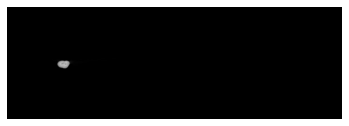

In [42]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
#msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [43]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [44]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [45]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [46]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'original/{path}.png')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        truemsk = Image.open(f'roots/{path}.png')
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        truemsk = np.stack((truemsk,)*3, axis=-1)
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, truemsk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Epoch 1/30
120/120 [==============================] - ETA: 0s - loss: 0.0970 - mean_iou: 1.5153e-04i= 1 loss= 0.0969947800040245 val_loss= 0.007424959912896156 mean_iou= 0.00015153262938838452 val_mean_iou= 0.0


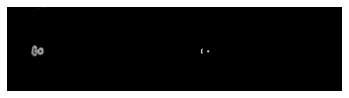

120/120 [==============================] - 38s 321ms/step - loss: 0.0970 - mean_iou: 1.5153e-04 - val_loss: 0.0074 - val_mean_iou: 0.0000e+00
Epoch 2/30
120/120 [==============================] - ETA: 0s - loss: 0.0061 - mean_iou: 2.8360e-05i= 2 loss= 0.006097130477428436 val_loss= 0.004328148439526558 mean_iou= 2.8360002033878118e-05 val_mean_iou= 7.44213757570833e-05


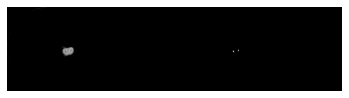

120/120 [==============================] - 37s 307ms/step - loss: 0.0061 - mean_iou: 2.8360e-05 - val_loss: 0.0043 - val_mean_iou: 7.4421e-05
Epoch 3/30
120/120 [==============================] - ETA: 0s - loss: 0.0031 - mean_iou: 0.3342i= 3 loss= 0.0031120246276259422 val_loss= 0.0032545358408242464 mean_iou= 0.334177702665329 val_mean_iou= 0.37177643179893494


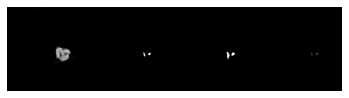

120/120 [==============================] - 37s 306ms/step - loss: 0.0031 - mean_iou: 0.3342 - val_loss: 0.0033 - val_mean_iou: 0.3718
Epoch 4/30
120/120 [==============================] - ETA: 0s - loss: 0.0021 - mean_iou: 0.6134i= 4 loss= 0.002124560298398137 val_loss= 0.0019861843902617693 mean_iou= 0.6133984923362732 val_mean_iou= 0.6076516509056091


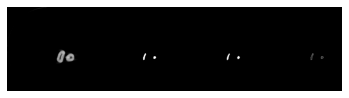

120/120 [==============================] - 37s 304ms/step - loss: 0.0021 - mean_iou: 0.6134 - val_loss: 0.0020 - val_mean_iou: 0.6077
Epoch 5/30
120/120 [==============================] - ETA: 0s - loss: 0.0016 - mean_iou: 0.6846i= 5 loss= 0.0016489006811752915 val_loss= 0.0015656809555366635 mean_iou= 0.6845678687095642 val_mean_iou= 0.7165719866752625


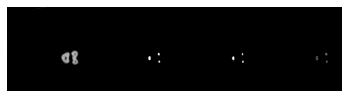

120/120 [==============================] - 36s 304ms/step - loss: 0.0016 - mean_iou: 0.6846 - val_loss: 0.0016 - val_mean_iou: 0.7166
Epoch 6/30
120/120 [==============================] - ETA: 0s - loss: 0.0015 - mean_iou: 0.7161i= 6 loss= 0.001511419308371842 val_loss= 0.0017234351253136992 mean_iou= 0.716133713722229 val_mean_iou= 0.6974360346794128


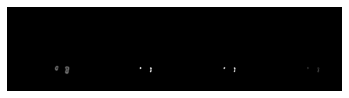

120/120 [==============================] - 36s 303ms/step - loss: 0.0015 - mean_iou: 0.7161 - val_loss: 0.0017 - val_mean_iou: 0.6974
Epoch 7/30
120/120 [==============================] - ETA: 0s - loss: 0.0013 - mean_iou: 0.7490i= 7 loss= 0.0012915481347590685 val_loss= 0.0011315670562908053 mean_iou= 0.7489652633666992 val_mean_iou= 0.781411349773407


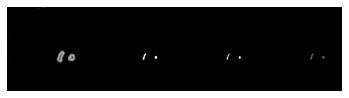

120/120 [==============================] - 39s 323ms/step - loss: 0.0013 - mean_iou: 0.7490 - val_loss: 0.0011 - val_mean_iou: 0.7814
Epoch 8/30
120/120 [==============================] - ETA: 0s - loss: 0.0012 - mean_iou: 0.7587i= 8 loss= 0.0012287121498957276 val_loss= 0.0013472175924107432 mean_iou= 0.7587470412254333 val_mean_iou= 0.7672183513641357


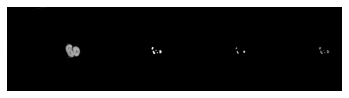

120/120 [==============================] - 38s 319ms/step - loss: 0.0012 - mean_iou: 0.7587 - val_loss: 0.0013 - val_mean_iou: 0.7672
Epoch 9/30
120/120 [==============================] - ETA: 0s - loss: 0.0011 - mean_iou: 0.7774i= 9 loss= 0.0010876769665628672 val_loss= 0.0011665105121210217 mean_iou= 0.7773990035057068 val_mean_iou= 0.7671945095062256


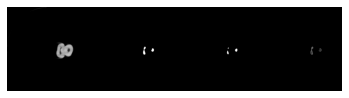

120/120 [==============================] - 38s 319ms/step - loss: 0.0011 - mean_iou: 0.7774 - val_loss: 0.0012 - val_mean_iou: 0.7672
Epoch 10/30
120/120 [==============================] - ETA: 0s - loss: 0.0010 - mean_iou: 0.7928i= 10 loss= 0.0010072820587083697 val_loss= 0.0009366183658130467 mean_iou= 0.7928206920623779 val_mean_iou= 0.8185403943061829


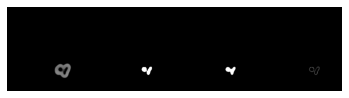

120/120 [==============================] - 38s 320ms/step - loss: 0.0010 - mean_iou: 0.7928 - val_loss: 9.3662e-04 - val_mean_iou: 0.8185
Epoch 11/30
120/120 [==============================] - ETA: 0s - loss: 9.4330e-04 - mean_iou: 0.8001i= 11 loss= 0.0009432957740500569 val_loss= 0.000926008156966418 mean_iou= 0.8000929951667786 val_mean_iou= 0.8234265446662903


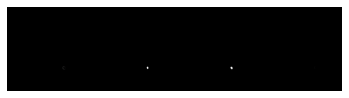

120/120 [==============================] - 37s 307ms/step - loss: 9.4330e-04 - mean_iou: 0.8001 - val_loss: 9.2601e-04 - val_mean_iou: 0.8234
Epoch 12/30
120/120 [==============================] - ETA: 0s - loss: 8.7599e-04 - mean_iou: 0.8142i= 12 loss= 0.000875986588653177 val_loss= 0.0007913373410701752 mean_iou= 0.814156174659729 val_mean_iou= 0.82711261510849


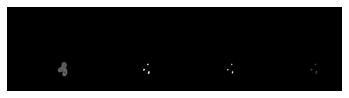

120/120 [==============================] - 37s 310ms/step - loss: 8.7599e-04 - mean_iou: 0.8142 - val_loss: 7.9134e-04 - val_mean_iou: 0.8271
Epoch 13/30
120/120 [==============================] - ETA: 0s - loss: 8.3590e-04 - mean_iou: 0.8219i= 13 loss= 0.0008359007770195603 val_loss= 0.0009878617711365223 mean_iou= 0.821881890296936 val_mean_iou= 0.828892707824707


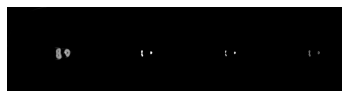

120/120 [==============================] - 36s 304ms/step - loss: 8.3590e-04 - mean_iou: 0.8219 - val_loss: 9.8786e-04 - val_mean_iou: 0.8289
Epoch 14/30
120/120 [==============================] - ETA: 0s - loss: 7.9474e-04 - mean_iou: 0.8284i= 14 loss= 0.0007947405683808029 val_loss= 0.0008524591685272753 mean_iou= 0.8283600211143494 val_mean_iou= 0.8407250046730042


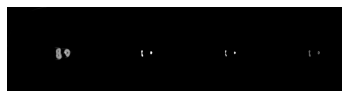

120/120 [==============================] - 37s 305ms/step - loss: 7.9474e-04 - mean_iou: 0.8284 - val_loss: 8.5246e-04 - val_mean_iou: 0.8407
Epoch 15/30
120/120 [==============================] - ETA: 0s - loss: 7.8068e-04 - mean_iou: 0.8326i= 15 loss= 0.0007806830108165741 val_loss= 0.0008668522932566702 mean_iou= 0.8326089382171631 val_mean_iou= 0.833744466304779


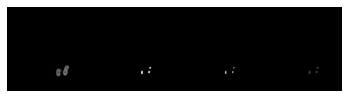

120/120 [==============================] - 36s 304ms/step - loss: 7.8068e-04 - mean_iou: 0.8326 - val_loss: 8.6685e-04 - val_mean_iou: 0.8337
Epoch 16/30
120/120 [==============================] - ETA: 0s - loss: 7.4872e-04 - mean_iou: 0.8370i= 16 loss= 0.0007487175753340125 val_loss= 0.0008839413640089333 mean_iou= 0.8369522094726562 val_mean_iou= 0.8314282894134521


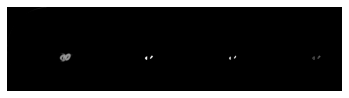

120/120 [==============================] - 37s 308ms/step - loss: 7.4872e-04 - mean_iou: 0.8370 - val_loss: 8.8394e-04 - val_mean_iou: 0.8314
Epoch 17/30
120/120 [==============================] - ETA: 0s - loss: 7.3992e-04 - mean_iou: 0.8420i= 17 loss= 0.0007399226306006312 val_loss= 0.0008320768247358501 mean_iou= 0.8420466184616089 val_mean_iou= 0.8173545002937317


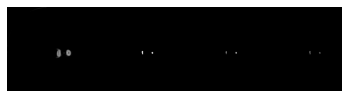

120/120 [==============================] - 36s 296ms/step - loss: 7.3992e-04 - mean_iou: 0.8420 - val_loss: 8.3208e-04 - val_mean_iou: 0.8174
Epoch 18/30
120/120 [==============================] - ETA: 0s - loss: 7.0852e-04 - mean_iou: 0.8455i= 18 loss= 0.0007085165125317872 val_loss= 0.0006815287633799016 mean_iou= 0.845499575138092 val_mean_iou= 0.8715528845787048


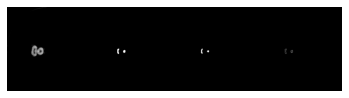

120/120 [==============================] - 37s 309ms/step - loss: 7.0852e-04 - mean_iou: 0.8455 - val_loss: 6.8153e-04 - val_mean_iou: 0.8716
Epoch 19/30
120/120 [==============================] - ETA: 0s - loss: 6.7036e-04 - mean_iou: 0.8524i= 19 loss= 0.0006703571998514235 val_loss= 0.0007163502741605043 mean_iou= 0.8524020910263062 val_mean_iou= 0.8617985248565674


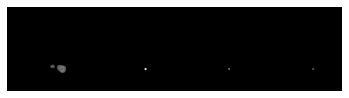

120/120 [==============================] - 35s 291ms/step - loss: 6.7036e-04 - mean_iou: 0.8524 - val_loss: 7.1635e-04 - val_mean_iou: 0.8618
Epoch 20/30
120/120 [==============================] - ETA: 0s - loss: 6.6632e-04 - mean_iou: 0.8521i= 20 loss= 0.0006663186941295862 val_loss= 0.0013128203572705388 mean_iou= 0.8520908951759338 val_mean_iou= 0.8169329166412354


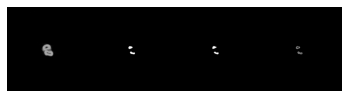

120/120 [==============================] - 35s 293ms/step - loss: 6.6632e-04 - mean_iou: 0.8521 - val_loss: 0.0013 - val_mean_iou: 0.8169
Epoch 21/30
120/120 [==============================] - ETA: 0s - loss: 6.3840e-04 - mean_iou: 0.8571i= 21 loss= 0.0006384022999554873 val_loss= 0.0007669864571653306 mean_iou= 0.8570922613143921 val_mean_iou= 0.8225764632225037


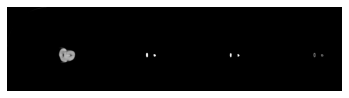

120/120 [==============================] - 37s 308ms/step - loss: 6.3840e-04 - mean_iou: 0.8571 - val_loss: 7.6699e-04 - val_mean_iou: 0.8226
Epoch 22/30
120/120 [==============================] - ETA: 0s - loss: 6.6274e-04 - mean_iou: 0.8555i= 22 loss= 0.0006627447437494993 val_loss= 0.0007102173403836787 mean_iou= 0.8554832935333252 val_mean_iou= 0.8613815307617188


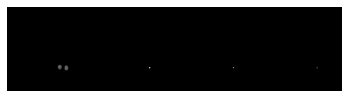

120/120 [==============================] - 37s 308ms/step - loss: 6.6274e-04 - mean_iou: 0.8555 - val_loss: 7.1022e-04 - val_mean_iou: 0.8614
Epoch 23/30
120/120 [==============================] - ETA: 0s - loss: 6.2599e-04 - mean_iou: 0.8616i= 23 loss= 0.00062598567456007 val_loss= 0.00080067542148754 mean_iou= 0.8616263270378113 val_mean_iou= 0.8547813892364502


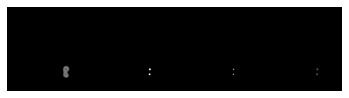

120/120 [==============================] - 37s 308ms/step - loss: 6.2599e-04 - mean_iou: 0.8616 - val_loss: 8.0068e-04 - val_mean_iou: 0.8548
Epoch 24/30
120/120 [==============================] - ETA: 0s - loss: 6.2687e-04 - mean_iou: 0.8588i= 24 loss= 0.0006268669385462999 val_loss= 0.0009428840130567551 mean_iou= 0.8587941527366638 val_mean_iou= 0.8448752760887146


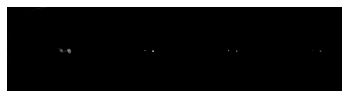

120/120 [==============================] - 38s 315ms/step - loss: 6.2687e-04 - mean_iou: 0.8588 - val_loss: 9.4288e-04 - val_mean_iou: 0.8449
Epoch 25/30
120/120 [==============================] - ETA: 0s - loss: 6.1336e-04 - mean_iou: 0.8663i= 25 loss= 0.0006133593851700425 val_loss= 0.0009324524435214698 mean_iou= 0.866318941116333 val_mean_iou= 0.8490632176399231


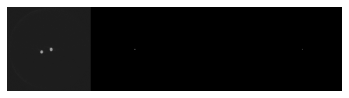

120/120 [==============================] - 38s 314ms/step - loss: 6.1336e-04 - mean_iou: 0.8663 - val_loss: 9.3245e-04 - val_mean_iou: 0.8491
Epoch 26/30
120/120 [==============================] - ETA: 0s - loss: 5.7459e-04 - mean_iou: 0.8717i= 26 loss= 0.0005745887756347656 val_loss= 0.0007437243475578725 mean_iou= 0.8716752529144287 val_mean_iou= 0.8587779998779297


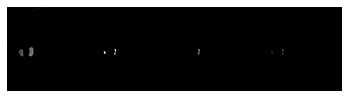

120/120 [==============================] - 38s 314ms/step - loss: 5.7459e-04 - mean_iou: 0.8717 - val_loss: 7.4372e-04 - val_mean_iou: 0.8588
Epoch 27/30
120/120 [==============================] - ETA: 0s - loss: 5.9217e-04 - mean_iou: 0.8701i= 27 loss= 0.0005921664997003973 val_loss= 0.0008828307036310434 mean_iou= 0.8700546026229858 val_mean_iou= 0.8126145005226135


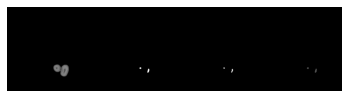

120/120 [==============================] - 38s 316ms/step - loss: 5.9217e-04 - mean_iou: 0.8701 - val_loss: 8.8283e-04 - val_mean_iou: 0.8126
Epoch 28/30
120/120 [==============================] - ETA: 0s - loss: 5.8411e-04 - mean_iou: 0.8672i= 28 loss= 0.0005841149832122028 val_loss= 0.0008512312197126448 mean_iou= 0.8671695590019226 val_mean_iou= 0.8277273178100586


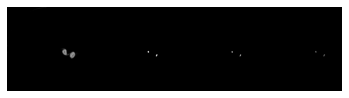

120/120 [==============================] - 38s 319ms/step - loss: 5.8411e-04 - mean_iou: 0.8672 - val_loss: 8.5123e-04 - val_mean_iou: 0.8277
Epoch 29/30
120/120 [==============================] - ETA: 0s - loss: 5.7450e-04 - mean_iou: 0.8720i= 29 loss= 0.0005744957597926259 val_loss= 0.0006266303244046867 mean_iou= 0.8719860911369324 val_mean_iou= 0.8593084812164307


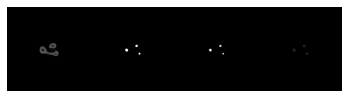

120/120 [==============================] - 38s 318ms/step - loss: 5.7450e-04 - mean_iou: 0.8720 - val_loss: 6.2663e-04 - val_mean_iou: 0.8593
Epoch 30/30
120/120 [==============================] - ETA: 0s - loss: 5.7777e-04 - mean_iou: 0.8710i= 30 loss= 0.0005777669721283019 val_loss= 0.0006303802947513759 mean_iou= 0.8709851503372192 val_mean_iou= 0.8738883137702942


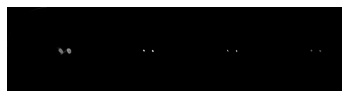

120/120 [==============================] - 38s 319ms/step - loss: 5.7777e-04 - mean_iou: 0.8710 - val_loss: 6.3038e-04 - val_mean_iou: 0.8739


In [47]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

In [48]:
history = _

In [49]:
history.history["val_mean_iou"]

[0.0,
 7.44213757570833e-05,
 0.37177643179893494,
 0.6076516509056091,
 0.7165719866752625,
 0.6974360346794128,
 0.781411349773407,
 0.7672183513641357,
 0.7671945095062256,
 0.8185403943061829,
 0.8234265446662903,
 0.82711261510849,
 0.828892707824707,
 0.8407250046730042,
 0.833744466304779,
 0.8314282894134521,
 0.8173545002937317,
 0.8715528845787048,
 0.8617985248565674,
 0.8169329166412354,
 0.8225764632225037,
 0.8613815307617188,
 0.8547813892364502,
 0.8448752760887146,
 0.8490632176399231,
 0.8587779998779297,
 0.8126145005226135,
 0.8277273178100586,
 0.8593084812164307,
 0.8738883137702942]

In [50]:
with open("history.json", "w") as fp:
    json.dump(history.history, fp)

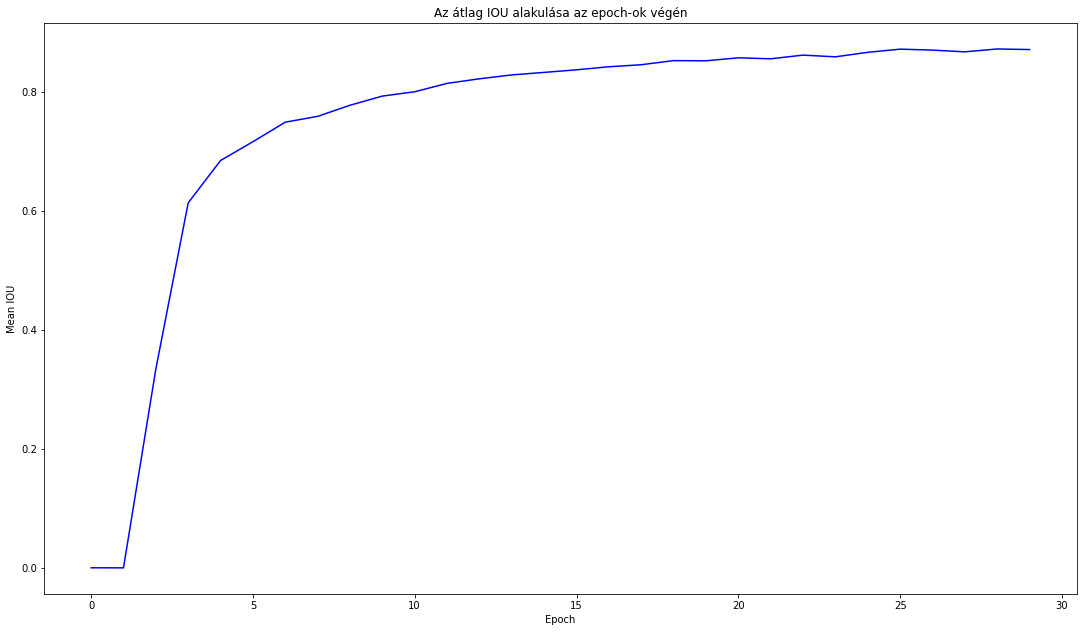

In [51]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_ylabel('Mean IOU')
ax.set_xlabel("Epoch")
ax.set_title('Az átlag IOU alakulása az epoch-ok végén')
plt.plot(range(len(history.history["mean_iou"])), history.history["mean_iou"], "b-")

# Loading

In [13]:
model.load_weights("unet.h5")

In [52]:
from scipy.spatial.distance import directed_hausdorff
from tqdm.notebook import tqdm, trange

def vecHausdorff(Y, P):
    dist = []
    for i in range(Y.shape[0]):
        o = directed_hausdorff(Y[i], P[i])[0]
        v = directed_hausdorff(P[i], Y[i])[0]
        dist.append(max(o,v))
        
    return np.array(dist)
        

def pairwise_iou(y_true, y_pred):
    yt0 = y_true
    yp0 = y_pred
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)), axis=(1,2))
    union = tf.math.count_nonzero(tf.add(yt0, yp0), axis=(1,2))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou.numpy()

def calcMetricsForImges(Y, P):
    # X is array of images in RGB
    # Y is array of masks in GRAY and Binarised
    # P is the predicted mask in GRAY and Binarised
    iou = pairwise_iou(Y, P) # IOU, aka. Jaccard index
    dice = (2*iou) / (iou + np.ones(iou.shape)) # Dice Coeff
    hdorf = vecHausdorff(Y, P)
    maskintenseity = np.count_nonzero(Y, axis=(1,2))
    predintensity = np.count_nonzero(P, axis=(1,2))
    return np.array([iou, dice, hdorf, maskintenseity, predintensity])

def processImages(r):
    
    imgPaths = [f"original/{i}.png" for i in r]
    mskPaths = [f"roots/{i}.png" for i in r]
    
    outs = []
    
    for i in range(len(r)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        metrics = calcMetricsForImges(np.array([truemsk,]), np.array([msk,]))
        print(f"IOU: {metrics[0,0]}")
        
        diff = truemsk != msk
        diff = diff.astype(np.float)
        
        truemsk = np.stack((truemsk,)*3, axis=-1)
        msk = np.stack((msk,)*3, axis=-1)
        diff = np.stack((diff,)*3, axis=-1)
        #show the mask and the segmented image 
        
        combined = np.concatenate([raw, msk, truemsk, diff], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

IOU: 0.2631579041481018


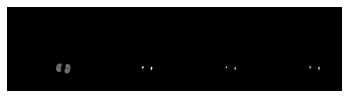

IOU: 0.4038461446762085


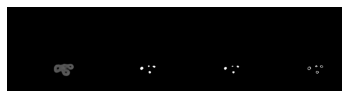

IOU: 0.5179855823516846


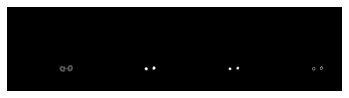

IOU: 0.3354838788509369


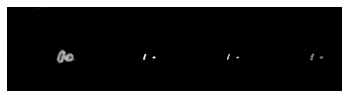

In [53]:
res = processImages([500, 1000, 1500, 3000])

In [54]:
res[0].shape

TypeError: 'NoneType' object is not subscriptable

# Testing and Validating

In [55]:
arr = pairwise_iou(np.array([img,msk]), np.array([msk,msk]))
directed_hausdorff(msk[:,0], msk[:,0])

(0.0, 158, 247)

In [78]:


def validateTrainImages(model, r):
    imgPaths = [f"original/{i}.png" for i in r]
    mskPaths = [f"roots/{i}.png" for i in r]
    
    
    masks = []
    preds = []
    for i in trange(len(imgPaths)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        truemsk[truemsk >= 0.5] = 1 
        truemsk[truemsk < 0.5] = 0
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        masks.append(truemsk)
        preds.append(msk)
    
    metrics = calcMetricsForImges(np.array(masks), np.array(preds))
    metricsDF = pd.DataFrame(data=metrics.T, index=r, columns=["iou", "dice", "hdorf", "mask_intensity", "pred_intensity"])
    return metricsDF
    
    
    

In [79]:
metrics = validateTrainImages(model, test_files)

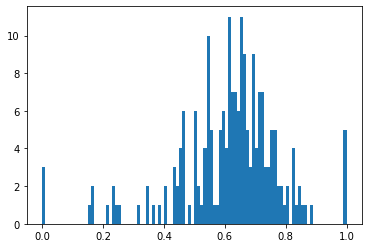

In [80]:
pieces, ranges, pl = plt.hist(metrics["iou"], bins=100)
# Az IOU eloszlása
# X tengely: IOU
# Y tengely: Abszolút előfordulás

In [81]:
np.insert(np.cumsum(pieces), 0, 0.0)

array([  0.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   3.,   3.,   3.,   3.,   4.,   6.,   6.,   6.,   6.,   6.,
         7.,   7.,   9.,  10.,  11.,  11.,  11.,  11.,  11.,  11.,  12.,
        12.,  12.,  14.,  14.,  15.,  15.,  16.,  16.,  18.,  18.,  18.,
        21.,  23.,  27.,  33.,  33.,  34.,  34.,  40.,  42.,  43.,  47.,
        57.,  62.,  63.,  64.,  69.,  75.,  79.,  90.,  97., 104., 110.,
       121., 130., 135., 138., 147., 151., 158., 165., 168., 171., 176.,
       181., 183., 185., 186., 188., 188., 192., 193., 195., 196., 197.,
       197., 198., 198., 198., 198., 198., 198., 198., 198., 198., 198.,
       198., 203.])

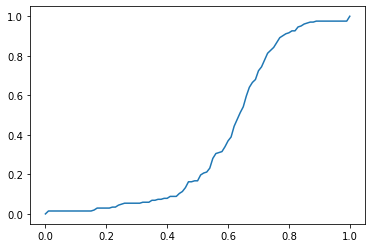

In [82]:
plt.plot(ranges, np.insert(np.cumsum(pieces), 0, 0.0) / np.cumsum(pieces)[-1])
# Az IOU kumulatív eloszlása
# X tengely: IOU
# Y tengely: kumulatív eloszlás

In [83]:
metrics["iou"]

580     0.639535
152     0.445783
2486    0.612717
1679    0.583333
2507    0.626667
          ...   
305     0.696335
26      0.640000
2254    0.651007
3008    0.834532
1619    0.597403
Name: iou, Length: 203, dtype: float64

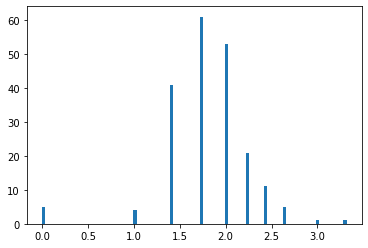

In [84]:
pieces, ranges, pl = plt.hist(metrics["hdorf"], bins=100)
# Huasdorf távolságok eloszlása

In [85]:
np.where(metrics["iou"] <= 0.01)

(array([18, 21, 94], dtype=int64),)

In [86]:
selected_tests = np.array([
    [6,57,185,455,601,619,729,825,986,1658],
    [1670,1732,1866,2443,3303],
    [75,171,373,1278,3298]
])

In [87]:
indexDF = pd.read_csv("ids.csv")

In [88]:
mxslices = indexDF.groupby("DID").agg({"slice" : [np.min, np.max]})
mxslices

slice     
     amin amax
DID           
0     253  329
1     136  234
2     145  247
3     152  249
4     150  226
5     146  233
6     178  236
7     153  246
8     169  251
9     177  270
10    147  253
11    159  253
12    137  215
13    150  214
14    156  223
15    168  251
16    173  274
17    170  263
18    159  251
19    143  241
20    161  235
21    249  335
22    285  374
23    272  374
24    259  353
25    269  371
26    272  322
27    281  366
28    272  361
29    270  352
30    276  347
31    224  286
32    288  374
33    279  353
34    262  336
35    297  363
36    272  344
37    237  326
38    228  303
39    271  333
40    281  372
41    283  370
42    237  321
43    267  343
44    246  305
45    269  339
46    292  344
47    234  315
48    235  313

In [89]:
merged = pd.merge(indexDF, mxslices, on="DID").drop(columns="Unnamed: 0")
merged["pos"] = (merged["slice"] - merged["slice", "amin"]) / (merged["slice", "amax"] - merged["slice", "amin"])
merged = merged.drop(columns=[["slice", "amax"], ["slice", "amin"]])
merged

C:\Users\szabo\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,GID,directory,slice,DID,pos
0,0,C:\Users\szabo\Documents\fogak\CBCT 14d_100,253,0,0.000000
1,1,C:\Users\szabo\Documents\fogak\CBCT 14d_100,254,0,0.013158
2,2,C:\Users\szabo\Documents\fogak\CBCT 14d_100,255,0,0.026316
3,3,C:\Users\szabo\Documents\fogak\CBCT 14d_100,256,0,0.039474
4,4,C:\Users\szabo\Documents\fogak\CBCT 14d_100,257,0,0.052632
...,...,...,...,...,...
4044,4044,C:\Users\szabo\Documents\fogak\CBCT 7d_100,309,48,0.948718
4045,4045,C:\Users\szabo\Documents\fogak\CBCT 7d_100,310,48,0.961538
4046,4046,C:\Users\szabo\Documents\fogak\CBCT 7d_100,311,48,0.974359
4047,4047,C:\Users\szabo\Documents\fogak\CBCT 7d_100,312,48,0.987179


In [90]:
combined = pd.merge(merged, metrics, left_index=True, right_index=True)
combined

,GID,directory,slice,DID,pos,iou,dice,hdorf,mask_intensity,pred_intensity
18,18,C:\Users\szabo\Documents\fogak\CBCT 14d_100,271,0,0.236842,0.552000,0.711340,2.000000,69.0,125.0
26,26,C:\Users\szabo\Documents\fogak\CBCT 14d_100,279,0,0.342105,0.640000,0.780488,1.732051,64.0,100.0
32,32,C:\Users\szabo\Documents\fogak\CBCT 14d_100,285,0,0.421053,0.625000,0.769231,1.732051,55.0,88.0
47,47,C:\Users\szabo\Documents\fogak\CBCT 14d_100,300,0,0.618421,0.236111,0.382022,2.645751,17.0,72.0
77,77,C:\Users\szabo\Documents\fogak\CBCT 201307231340,136,1,0.000000,0.784553,0.879271,2.000000,193.0,246.0
...,...,...,...,...,...,...,...,...,...,...
3913,3913,C:\Users\szabo\Documents\fogak\CBCT 5s_100,259,47,0.308642,0.615385,0.761905,2.000000,56.0,91.0
3938,3938,C:\Users\szabo\Documents\fogak\CBCT 5s_100,284,47,0.617284,0.545455,0.705882,2.000000,18.0,33.0
3975,3975,C:\Users\szabo\Documents\fogak\CBCT 7d_100,240,48,0.064103,0.512712,0.677871,2.449490,121.0,236.0
3986,3986,C:\Users\szabo\Documents\fogak\CBCT 7d_100,251,48,0.205128,0.762887,0.865497,1.732051,184.0,158.0


In [22]:
combined.to_csv("metrics.csv")

In [2]:
# Load saved metrics
combined = pd.read_csv("metrics.csv")

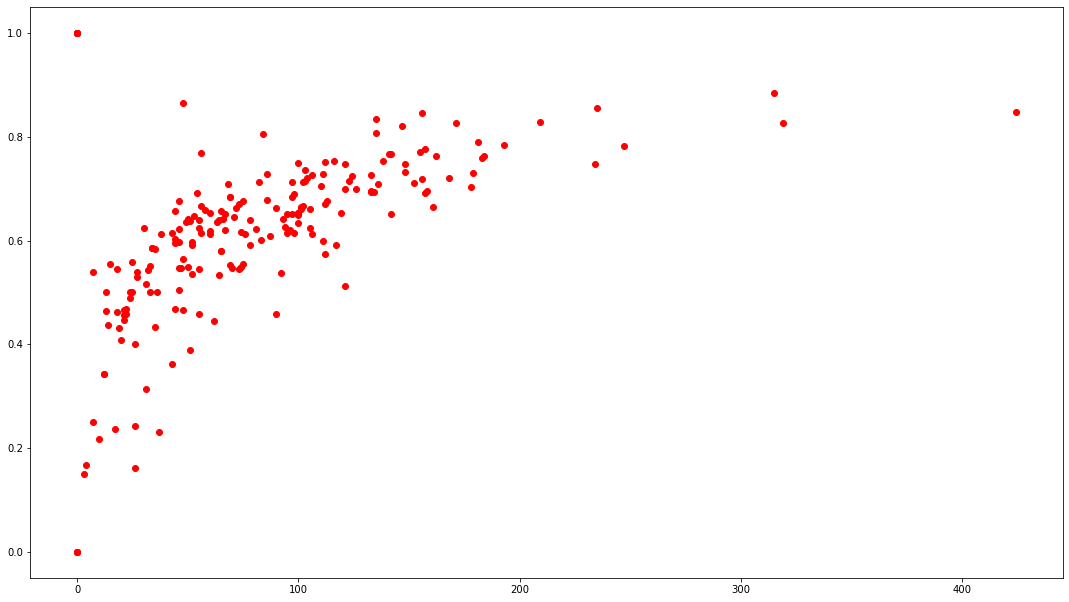

In [91]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(combined.mask_intensity, combined.iou, "ro")
# IOU eloszlása a maszk fehér pixeleniek függvényében
# X tengely: A maszk fehér pixeleinek száma
# Y tengely: IOU

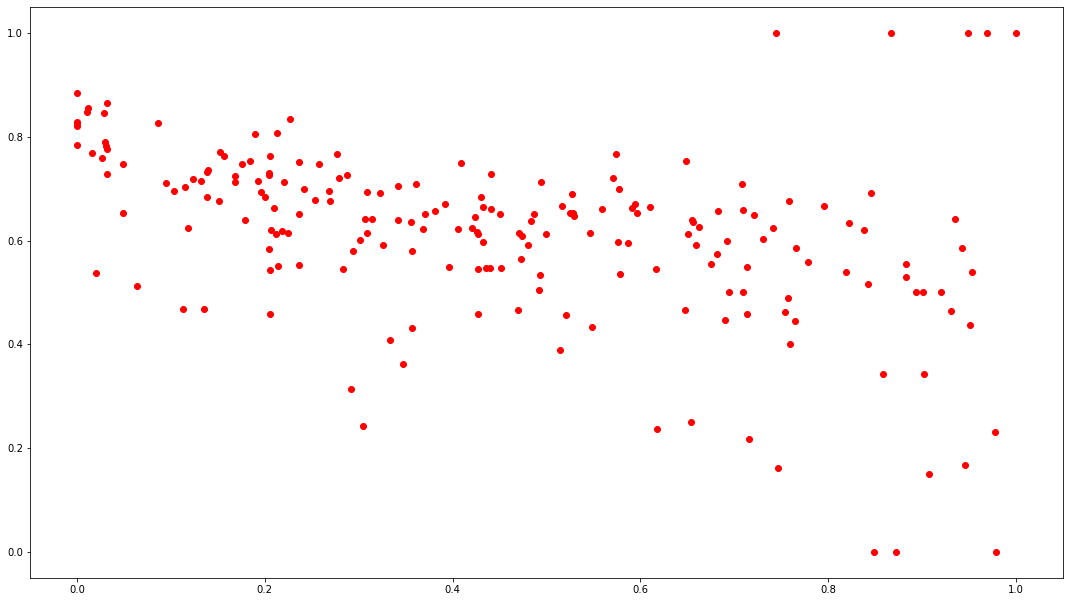

In [92]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(combined.pos, combined.iou, "ro")
# IOU eloszlása a szelet fogbeli elhelyezkedése alapján
# X tengely: A szelet fogbeli helye, ahol 0 az első szelet, amihez tartozik maszk és 1 az utolsó
# Y tengely: IOU

(-25.0, 525.0)

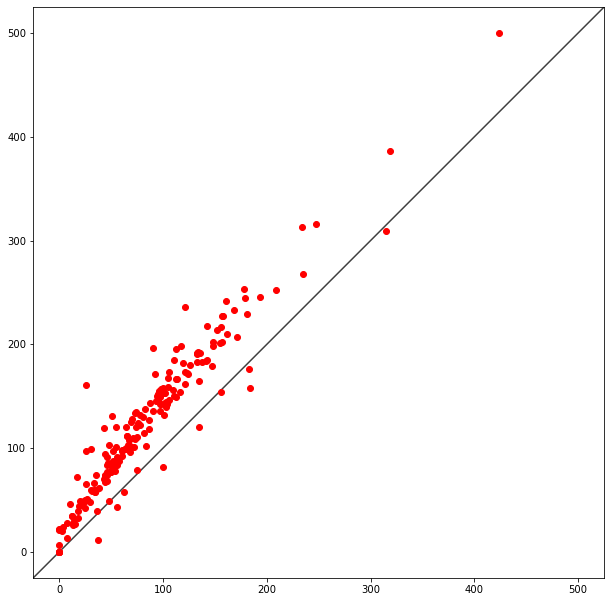

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(combined.mask_intensity, combined.pred_intensity, "ro")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Az elvárt és a kimeneti maszk fehér pixeleinek eloszlása
# X tengely: Az elvárt maszk fehér pixeleinek száma
# Y tengely: A kimeneti maszk fehér pixeleinek száma

In [94]:
histData2D = np.histogram2d(combined.mask_intensity, combined.pred_intensity, bins=(100,100))

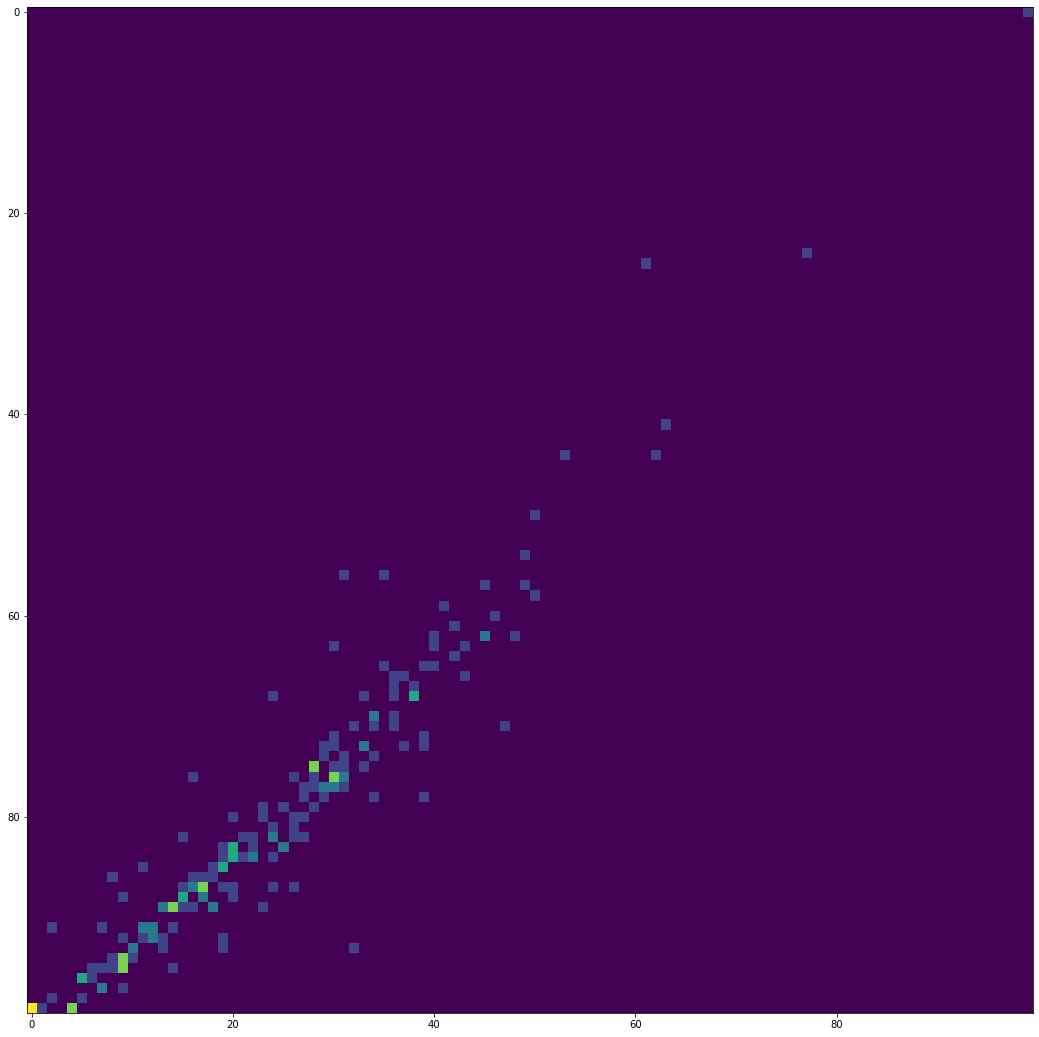

In [95]:
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plt.imshow(histData2D[0][::-1, :])

In [96]:
barData = combined[combined.iou < 0.1].groupby("DID").count() / combined.groupby("DID").count()

In [97]:
np.

SyntaxError: invalid syntax (<ipython-input-97-df0eca0bfa5c>, line 1)

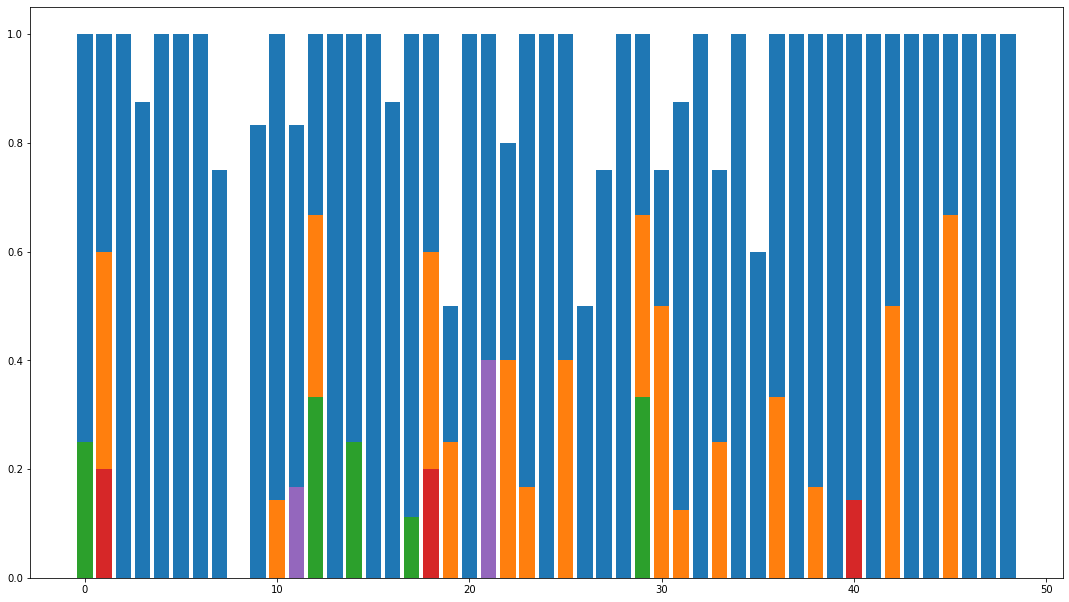

In [98]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
for limit in reversed([0.1, 0.2, 0.3, 0.5, 0.8]):
    barData = combined[combined.iou < limit].groupby("DID").count() / combined.groupby("DID").count()
    plt.bar(barData.index.values, barData.iou.values);
plt.show()

# Histogram a hibák relatív számának alakulásáról feogak szerint
# X tengely: a fog azonosítója
# Y tengely: A hibák relatív száma, ahol hibának vesszük a:
# lila: 0.1, piros : 0.2, zöld : 0.3, sárga : 0.5, kék : 0.8
# alatti IOU-val rendelkező képeket.

IOU: 0.0


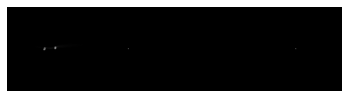

IOU: 0.0


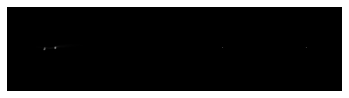

IOU: 0.0


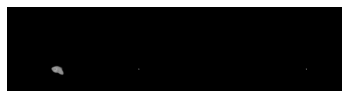

IOU: 0.0


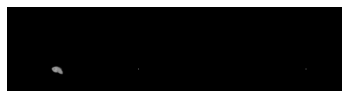

IOU: 0.0


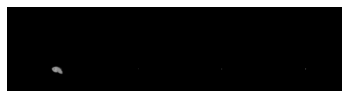

IOU: 0.04545454680919647


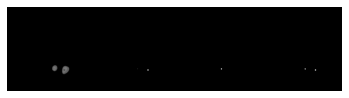

IOU: 0.0555555559694767


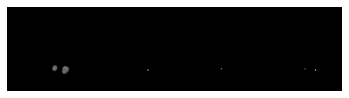

IOU: 0.0


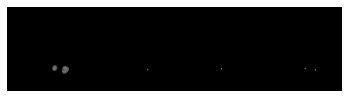

IOU: 0.0


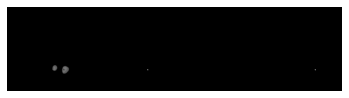

IOU: 0.0


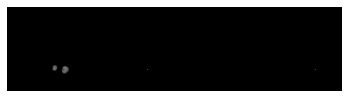

IOU: 0.0


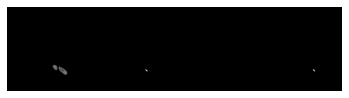

IOU: 0.0


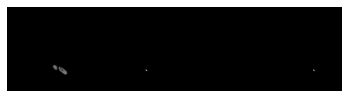

IOU: 0.0


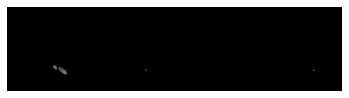

IOU: 0.0


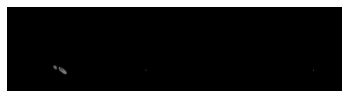

IOU: 0.0


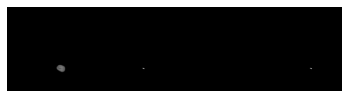

IOU: 0.0


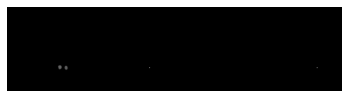

IOU: 0.0


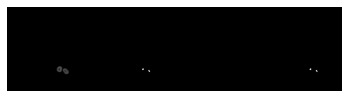

IOU: 0.0


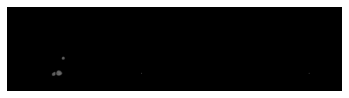

IOU: 0.0


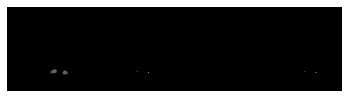

IOU: 0.0


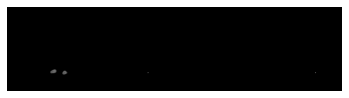

IOU: 0.0


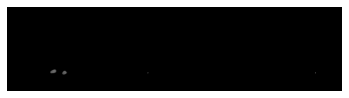

IOU: 0.0


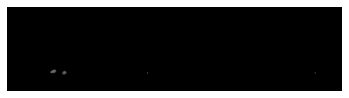

IOU: 0.0


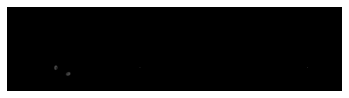

IOU: 0.0833333358168602


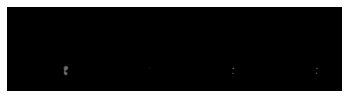

IOU: 0.06666667014360428


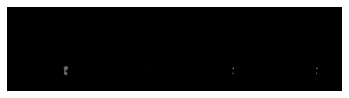

IOU: 0.0


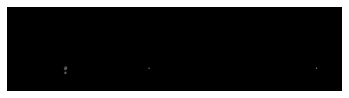

IOU: 0.0


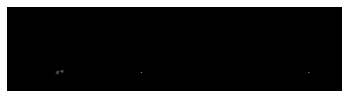

IOU: 0.0


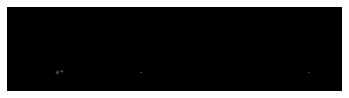

IOU: 0.0


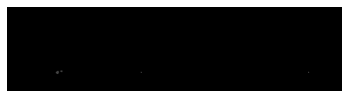

IOU: 0.0


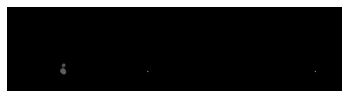

IOU: 0.0


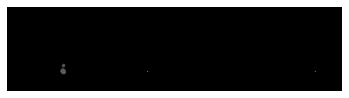

IOU: 0.0


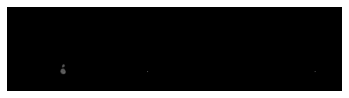

IOU: 0.0


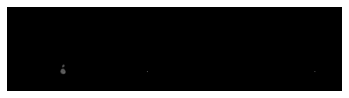

IOU: 0.0


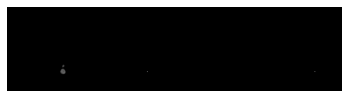

IOU: 0.0


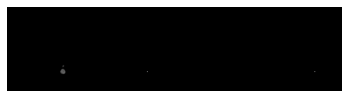

IOU: 0.0


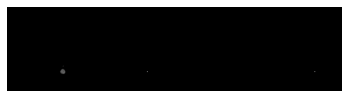

IOU: 0.0


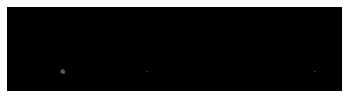

IOU: 0.0


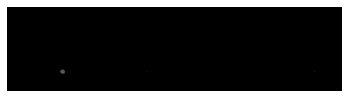

IOU: 0.0


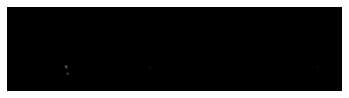

IOU: 0.0


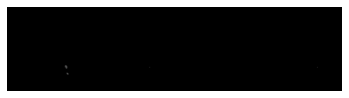

IOU: 0.0


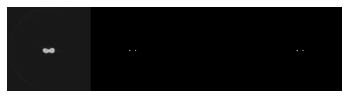

IOU: 0.0


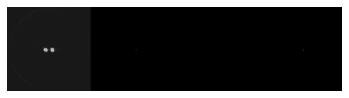

IOU: 0.0


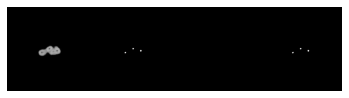

IOU: 0.0


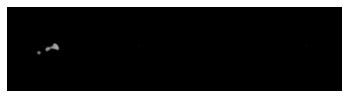

IOU: 0.0


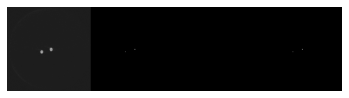

IOU: 0.0


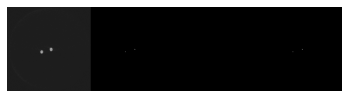

IOU: 0.0


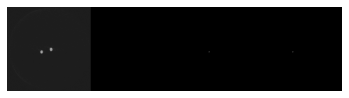

IOU: 0.0


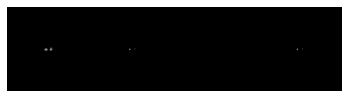

IOU: 0.0


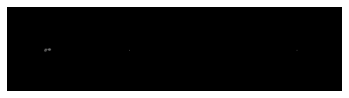

IOU: 0.0


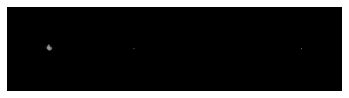

IOU: 0.0


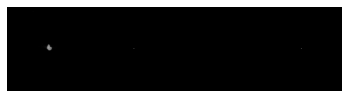

IOU: 0.0


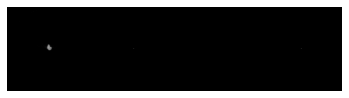

IOU: 0.0


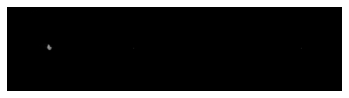

IOU: 0.0


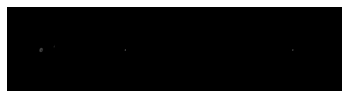

IOU: 0.0


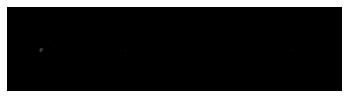

IOU: 0.0


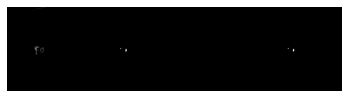

IOU: 0.0


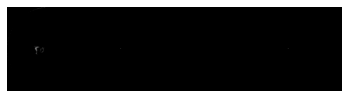

IOU: 0.0


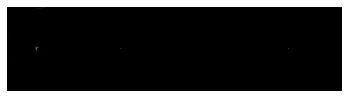

IOU: 0.0


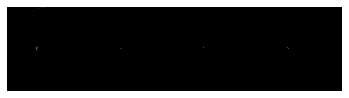

IOU: 0.0


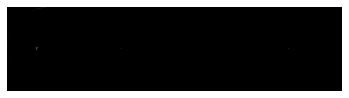

IOU: 0.0


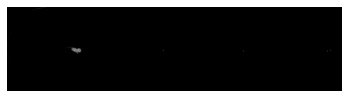

IOU: 0.0


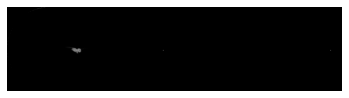

IOU: 0.0


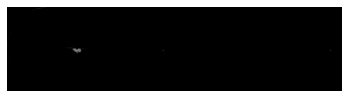

IOU: 0.0


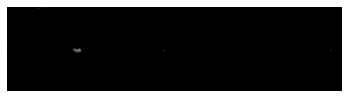

IOU: 0.0


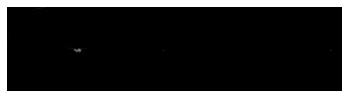

IOU: 0.0


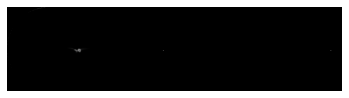

IOU: 0.0


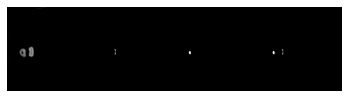

IOU: 0.0


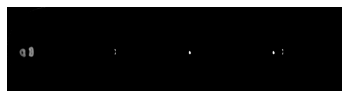

IOU: 0.06451612710952759


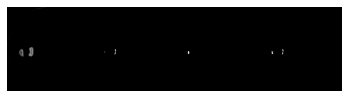

IOU: 0.0


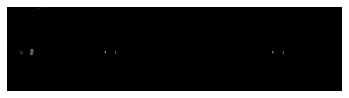

IOU: 0.0


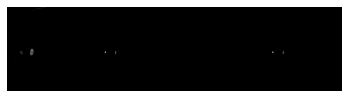

IOU: 0.0


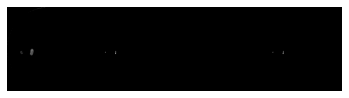

IOU: 0.0


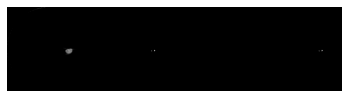

IOU: 0.0


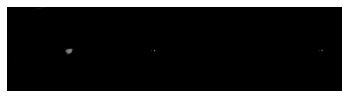

IOU: 0.0


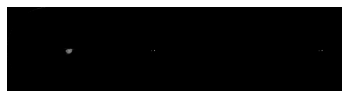

IOU: 0.0


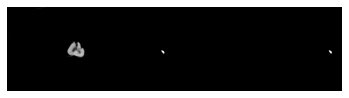

IOU: 0.0


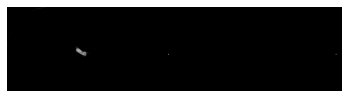

IOU: 0.0


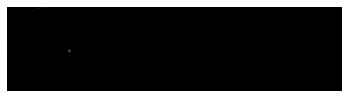

IOU: 0.0


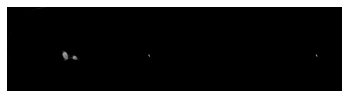

IOU: 0.0


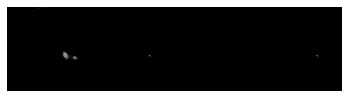

IOU: 0.0


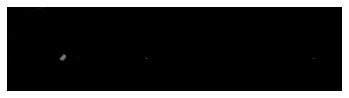

IOU: 0.0


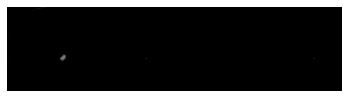

IOU: 0.0


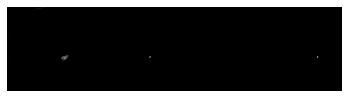

IOU: 0.0


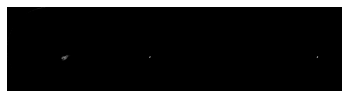

IOU: 0.0


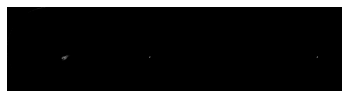

IOU: 0.0


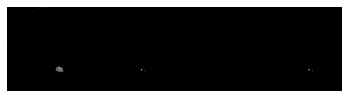

IOU: 0.0


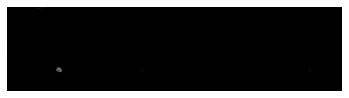

IOU: 0.0


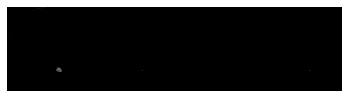

IOU: 0.0


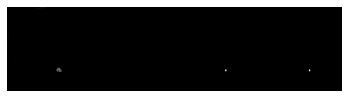

IOU: 0.0


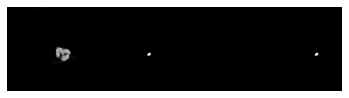

IOU: 0.0


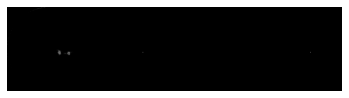

IOU: 0.0


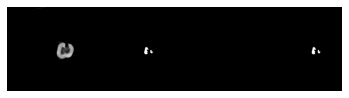

IOU: 0.0


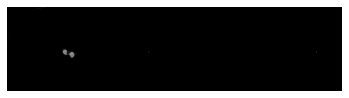

IOU: 0.0


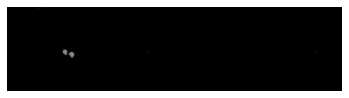

IOU: 0.0


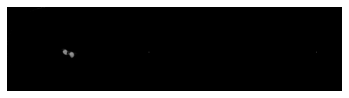

IOU: 0.0


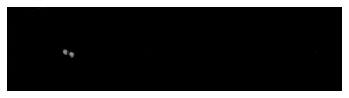

IOU: 0.0


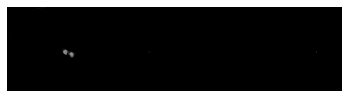

IOU: 0.0


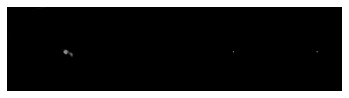

IOU: 0.0


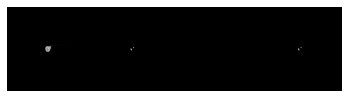

IOU: 0.0


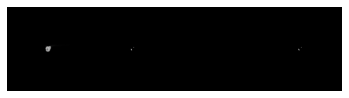

IOU: 0.0


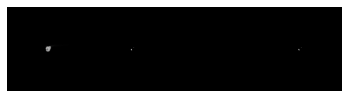

IOU: 0.0


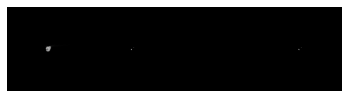

IOU: 0.0


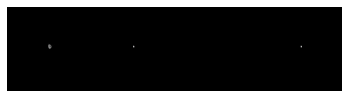

IOU: 0.0


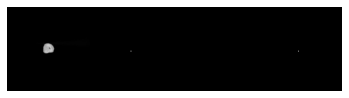

IOU: 0.0


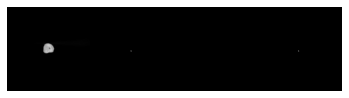

IOU: 0.0


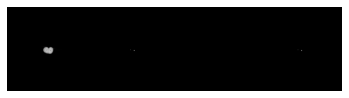

IOU: 0.0


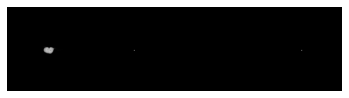

IOU: 0.0


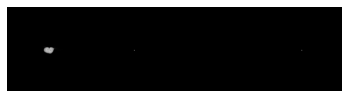

IOU: 0.0


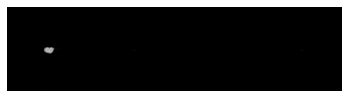

IOU: 0.0


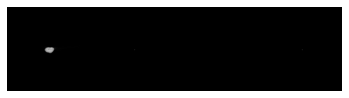

In [32]:
processImages(combined[combined.iou <= 0.1].index.values)

IOU: 1.0


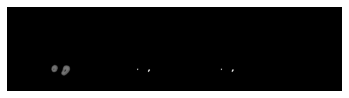

IOU: 1.0


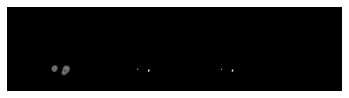

IOU: 1.0


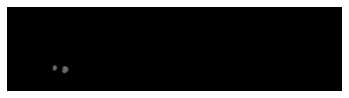

IOU: 1.0


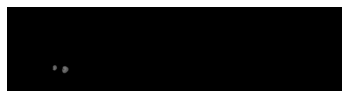

IOU: 1.0


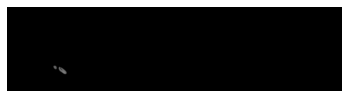

IOU: 1.0


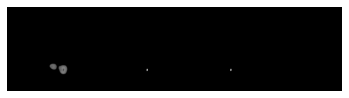

IOU: 1.0


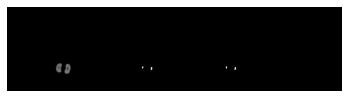

IOU: 1.0


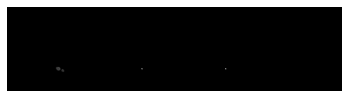

IOU: 1.0


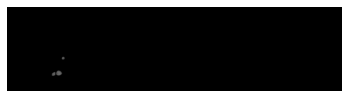

IOU: 1.0


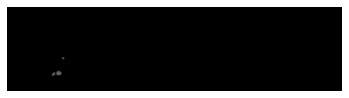

In [62]:
processImages(combined[combined.iou > 0.9999].index.values[:10])

In [36]:
avgiouPerTooth = combined.groupby("DID").agg({"iou":np.average})

In [39]:
avgiouPerTooth.columns

Index(['iou'], dtype='object')

<BarContainer object of 49 artists>

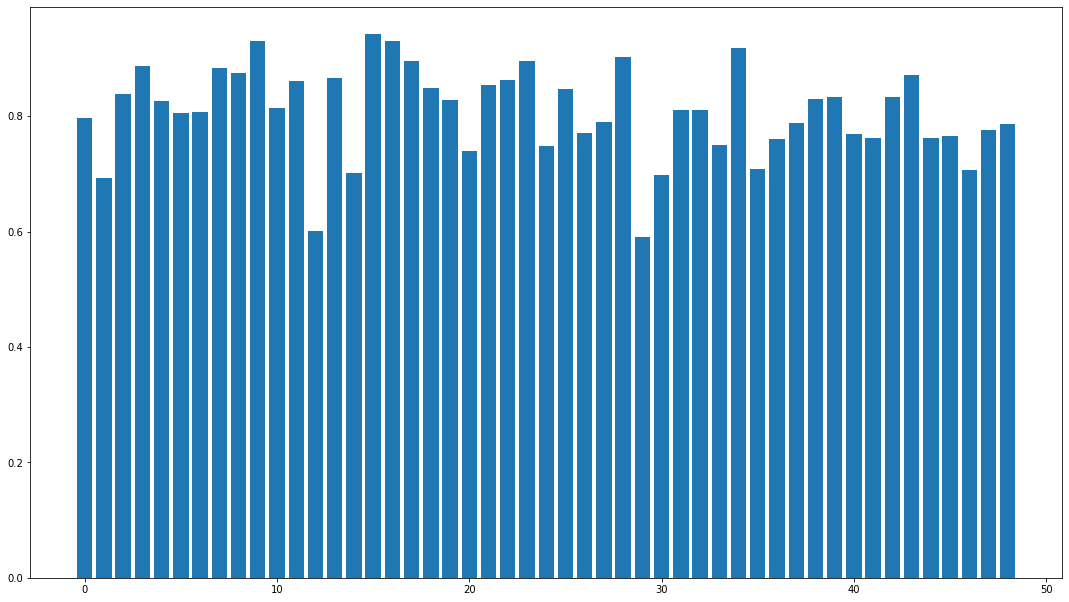

In [41]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.bar(avgiouPerTooth.index, avgiouPerTooth["iou"])
# Fogankénti átlagos IOU
# X tengely: a fog azonosítója
# Y tengely: átlagos IOU

In [56]:
combined.iou.quantile(np.linspace(0.0, 1.0, 11))
# Percentilisek, megmutatja, hogy meddig kell emelnünk az IOU felső korlátját, hogy az eredmények adott százalékát lefedjük

0.0    0.000000
0.1    0.565675
0.2    0.737705
0.3    0.812500
0.4    0.853490
0.5    0.882114
0.6    0.903452
0.7    0.923872
0.8    0.941860
0.9    0.963222
1.0    1.000000
Name: iou, dtype: float64

In [69]:
def showATeeth(did):
    ids = combined[combined.DID == did]["GID"].values
    imgPaths = [f"original/{i}.png" for i in ids]
    mskPaths = [f"roots/{i}.png" for i in ids]
    
    imgs = []
    
    for i in range(len(ids)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        imgs.append(raw[:,:,0])

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        
    data = np.array(imgs)
    print(data.shape)
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax = fig.gca(projection='3d')

    ax.voxels(data, alpha = 0.2)

plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

